In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [5]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
train_df = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_df = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
print(f"Train Dataset Shape - {train_df.shape}")
print(f"Test Dataset Shape - {test_df.shape}")

Train Dataset Shape - (60000, 785)
Test Dataset Shape - (10000, 785)


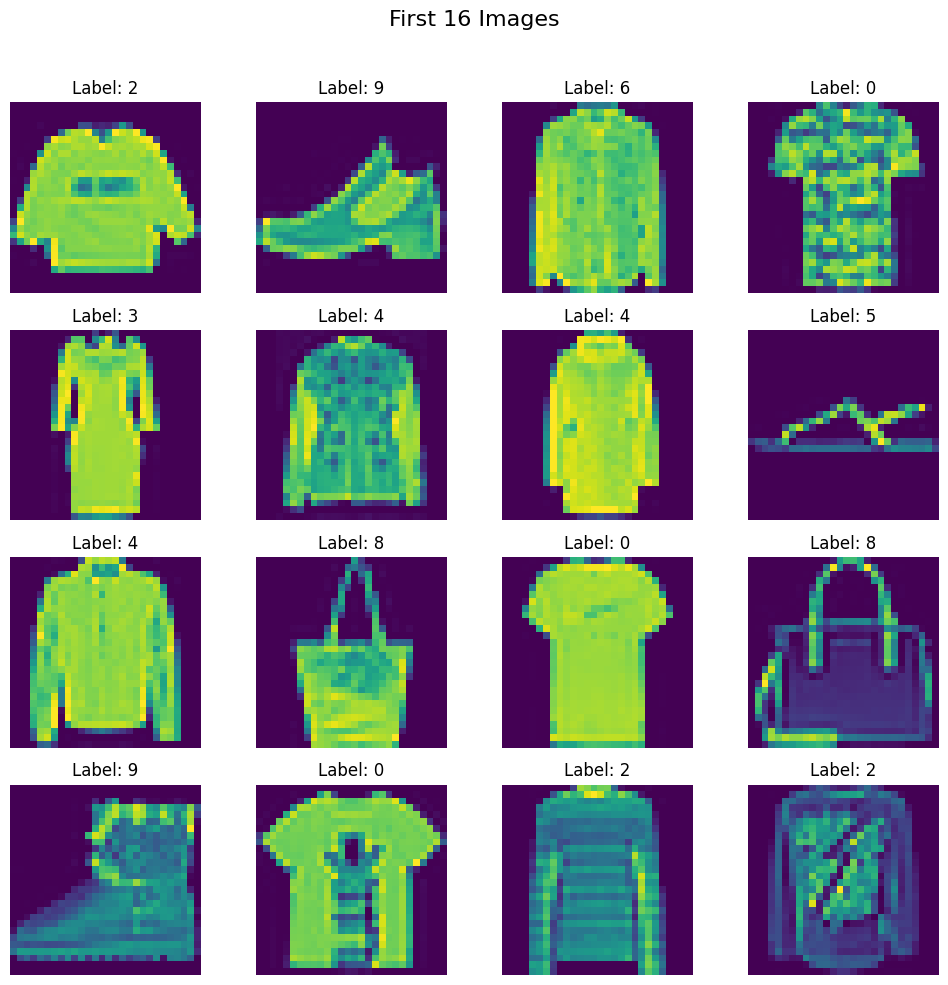

In [10]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = train_df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {train_df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [11]:
# seperating features and targets
X_train = train_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].values

X_test = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values

In [13]:
print(f"X_train Features Shape - {X_train.shape}")
print(f"X_test Features Shape - {y_train.shape}")

print(f"y_train Targets Shape - {X_test.shape}")
print(f"y_test Targets Shape - {y_test.shape}")

X_train Features Shape - (60000, 784)
X_test Features Shape - (60000,)
y_train Targets Shape - (10000, 784)
y_test Targets Shape - (10000,)


In [14]:
# Normalizing

X_train = X_train/255.0
X_test = X_test/255.0

In [15]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    # Need Images - convert 1D array of  
    self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [16]:
train_dataset = CustomDataset(X_train, y_train)

In [17]:
test_dataset = CustomDataset(X_test, y_test)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [40]:
class FashionMNISTCNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [41]:
learning_rate = 0.01
epochs = 50

In [42]:
model = FashionMNISTCNN(1)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [43]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.610303566590945
Epoch: 2 , Loss: 0.36720890760421754
Epoch: 3 , Loss: 0.3126713167121013
Epoch: 4 , Loss: 0.2837949852784475
Epoch: 5 , Loss: 0.25638155781626704
Epoch: 6 , Loss: 0.23838482000629108
Epoch: 7 , Loss: 0.22531852620244025
Epoch: 8 , Loss: 0.21002279029786586
Epoch: 9 , Loss: 0.20056476862256725
Epoch: 10 , Loss: 0.1858101532821854
Epoch: 11 , Loss: 0.17832586867958308
Epoch: 12 , Loss: 0.16770026440198224
Epoch: 13 , Loss: 0.16086322289705277
Epoch: 14 , Loss: 0.15045897284025947
Epoch: 15 , Loss: 0.1448555912747979
Epoch: 16 , Loss: 0.1361089478842914
Epoch: 17 , Loss: 0.12979373276916642
Epoch: 18 , Loss: 0.12297188927680254
Epoch: 19 , Loss: 0.1158563189888373
Epoch: 20 , Loss: 0.1114034533496946
Epoch: 21 , Loss: 0.11089298584113519
Epoch: 22 , Loss: 0.10369144437412421
Epoch: 23 , Loss: 0.09619009667299688
Epoch: 24 , Loss: 0.09670586293252806
Epoch: 25 , Loss: 0.08791334432003399
Epoch: 26 , Loss: 0.08536992648703357
Epoch: 27 , Loss: 0.0839811307

In [44]:
model.eval()

FashionMNISTCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [45]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9311


In [47]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9985166666666667


In [48]:
import torch
import torch.nn as nn # For the loss function
from tqdm import tqdm # For the progress bar
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, class_names):
    """
    Evaluates the performance of a PyTorch model on a test dataset.

    Args:
        model (nn.Module): The trained PyTorch model.
        test_loader (DataLoader): DataLoader for the test dataset.
        class_names (list): List of class names for the classification report.
    """
    # 1. Device Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval() # Set the model to evaluation mode
    criterion = nn.CrossEntropyLoss()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    # Lists to store all predictions and true labels for detailed metrics
    all_predictions = []
    all_targets = []

    # 2. Evaluation Loop
    with torch.no_grad(): # Disable gradient calculations
        # Add tqdm for a progress bar during evaluation
        for batch_features, batch_targets in tqdm(test_loader, desc="Evaluating"):
            
            # Insert this logic inside the evaluation loop:
            if batch_targets.dim() > 1 and batch_targets.size(1) > 1:
                # Converts one-hot targets back to class indices for CrossEntropyLoss
                batch_targets = torch.argmax(batch_targets, dim=1)
            # Move data to the appropriate device
            batch_features = batch_features.to(device)
            batch_targets = batch_targets.to(device)


            # Forward pass
            out = model(batch_features)
            
            # Calculate Loss
            loss = criterion(out, batch_targets)
            total_loss += loss.item() * batch_features.size(0) # Accumulate loss

            # Get predicted class (index with the highest probability)
            _, predicted = torch.max(out, 1)

            # Update accuracy metrics
            total_samples += batch_targets.size(0)
            total_correct += (predicted == batch_targets).sum().item()
            
            # Store predictions and targets for scikit-learn metrics
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())

    # 3. Calculate Final Metrics
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    print("\n" + "="*50)
    print("## ✨ Final Performance Metrics")
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f} ({total_correct}/{total_samples})")
    print("="*50 + "\n")

    # 4. Generate Classification Report
    print("## 📋 Classification Report")
    print(classification_report(all_targets, all_predictions, target_names=class_names, digits=4))

    # 5. Visualize Confusion Matrix
    print("## 🖼️ Confusion Matrix")
    # 
    cm = confusion_matrix(all_targets, all_predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


In [49]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Evaluating: 100%|██████████| 313/313 [00:00<00:00, 786.16it/s]



## ✨ Final Performance Metrics
Test Loss: 0.3534
Test Accuracy: 0.9311 (9311/10000)

## 📋 Classification Report
              precision    recall  f1-score   support

 T-shirt/top     0.8769    0.8830    0.8799      1000
     Trouser     0.9920    0.9910    0.9915      1000
    Pullover     0.9183    0.8770    0.8972      1000
       Dress     0.9231    0.9360    0.9295      1000
        Coat     0.8985    0.8940    0.8962      1000
      Sandal     0.9840    0.9820    0.9830      1000
       Shirt     0.8027    0.8180    0.8103      1000
     Sneaker     0.9604    0.9700    0.9652      1000
         Bag     0.9851    0.9890    0.9870      1000
  Ankle boot     0.9720    0.9710    0.9715      1000

    accuracy                         0.9311     10000
   macro avg     0.9313    0.9311    0.9311     10000
weighted avg     0.9313    0.9311    0.9311     10000

## 🖼️ Confusion Matrix


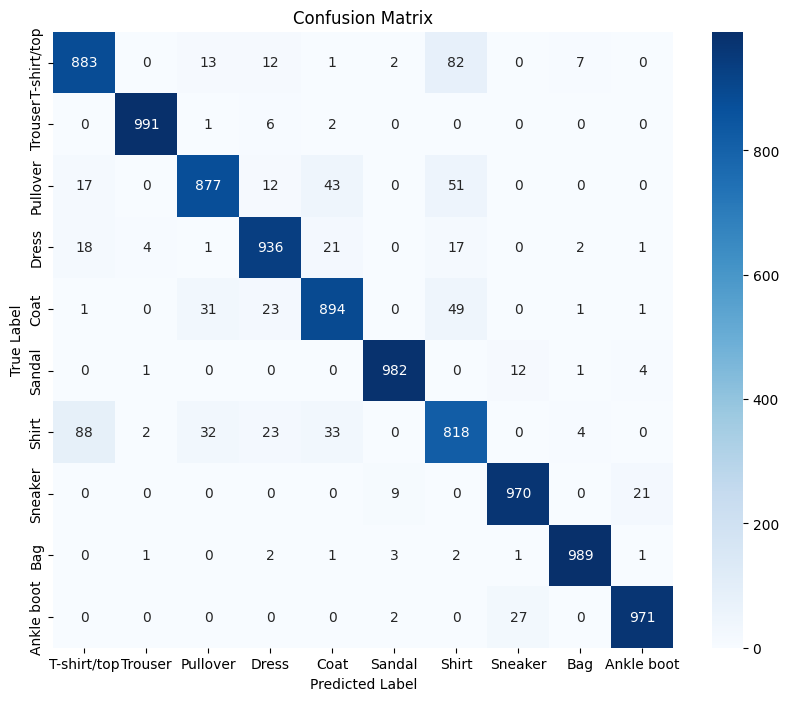

In [50]:
evaluate_model(model, test_loader, class_names)

In [ ]:
# With 100 epoch:

# test: 0.93
# train: 0.9995666666666667

# With 50 epoch

# test: 0.9311
# train: 0.9985

# With 25 epoch

# test: 0.9313
# train: 0.98